<a href="https://colab.research.google.com/github/ngmars/Siren-Detection-Ensemble-Learning/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Dataset Link**


[Urban Sounds Dataset (8k)](https://urbansounddataset.weebly.com/urbansound8k.html)



Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/ML: Siren Detector")

Import libraries

In [ ]:
import pandas as pd
import glob 
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm

Load Metadata

In [ ]:
data = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
data.shape

(8732, 8)


**METADATA**
*   slice_file_name: name of the audio file
*   fsID: FreesoundID of the recording where the excerpt is taken from
*   start: start time of the slice
*   end: end time of the slice
*   salience: salience rating of the sound. 1 = foreground, 2 = background
*   fold: The fold number (1–10) to which this file has been allocated
*   classID:
0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music
*   class: class name



In [ ]:
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
data['class'].value_counts()

drilling            1000
dog_bark            1000
jackhammer          1000
engine_idling       1000
street_music        1000
children_playing    1000
air_conditioner     1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

## Understanding features of Sound

Functions to plot the audio waves

In [ ]:
import struct
from scipy.io import wavfile as wav

def path_class(filename):
    excerpt = data[data['slice_file_name'] == filename]
    path_name = os.path.join('UrbanSound8K/audio', 'fold'+str(excerpt.fold.values[0]), filename)
    return path_name, excerpt['class'].values[0]

def wav_plotter(full_path, class_label):   
    rate, wav_sample = wav.read(full_path)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    print('sampling rate: ',rate,'Hz')
    print('bit depth: ',bit_depth)
    print('number of channels: ',wav_sample.shape[1])
    print('duration: ',wav_sample.shape[0]/rate,' second')
    print('number of samples: ',len(wav_sample))
    print('class: ',class_label)
    plt.figure(figsize=(12, 4))
    plt.plot(wav_sample) 
    return ipd.Audio(full_path)

**For the plot below**
X axis 

*   Sampling rate
*   is 44100 Hz
*   4 second duration
*   Max -> 44100 * 4 = 176400

Y axis 

*   Bit depth
*   is 16 bits
*   Max -> 65,536 values
*   -ve to +ve : -30k to +30k

sampling rate:  44100 Hz
bit depth:  16
number of channels:  2
duration:  4.0  second
number of samples:  176400
class:  siren


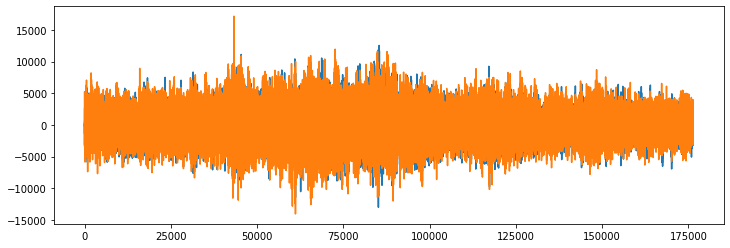

In [ ]:
full_path, label = path_class('102871-8-0-4.wav')
wav_plotter(full_path, label)

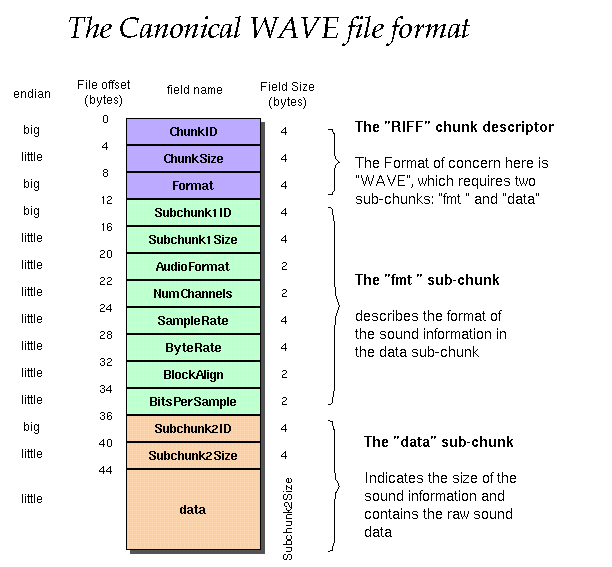

Parse the audio wave files

In [ ]:
def wav_fmt_parser(file_name):
    full_path, label = path_class(file_name)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    n_channels_string = riff_fmt[22:24]
    n_channels = struct.unpack("H",n_channels_string)[0]
    s_rate_string = riff_fmt[24:28]
    s_rate = struct.unpack("I",s_rate_string)[0]
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    return (n_channels,s_rate,bit_depth)

Add channels, sampling rate & bit depth features to the dataframe

In [ ]:
wav_fmt_data = []
for i in tqdm(data.slice_file_name):
    wav_fmt_data.append(wav_fmt_parser(i)) 

data[['n_channels','sampling_rate','bit_depth']] = pd.DataFrame(wav_fmt_data)
data.head()

  2%|▏         | 157/8732 [01:16<1:07:11,  2.13it/s]

KeyboardInterrupt: ignored

In [ ]:
data.sampling_rate.value_counts()

In [ ]:
data.n_channels.value_counts()

In [ ]:
data.bit_depth.value_counts()

# Sample rate conversion
Transform data to have the same shape (by converting sample rate to a single unifrom value) and mono-channel. This makes it easier to process with machine learning models.

In [ ]:
data[data.slice_file_name == '100652-3-0-1.wav']

,slice_file_name,fsID,start,end,salience,fold,classID,class
15,100652-3-0-1.wav,100652,0.5,4.5,1,2,3,dog_bark


Librosa will convert the sampling rate to 22.05khz, as well as reducing the number of channels to 1(mono), and normalize the data so that the values will range from -1 to 1.

converted sample rate: 22050
converted wav file min~max range: -0.3047009 ~ 0.3728283


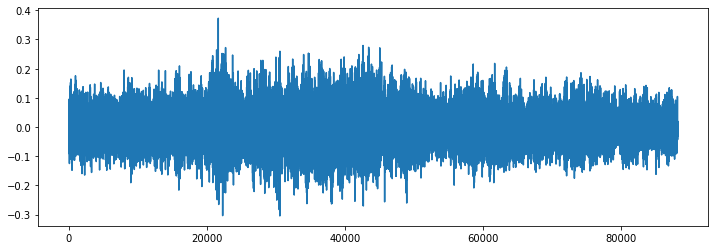

In [ ]:
import librosa

fullpath,label = path_class('102871-8-0-4.wav')
librosa_load, librosa_sampling_rate = librosa.load(fullpath)
print('converted sample rate:',librosa_sampling_rate)
print('converted wav file min~max range:',np.min(librosa_load),'~',np.max(librosa_load))
plt.figure(figsize=(12, 4))
plt.plot(librosa_load)

# Data augmentation

**Shift time**

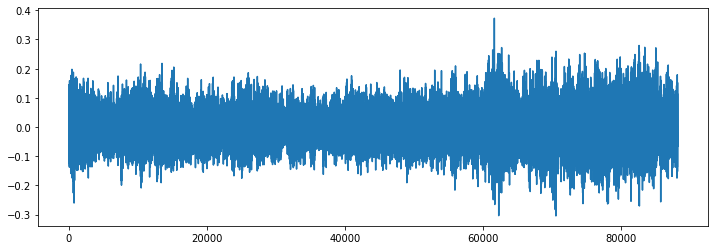

In [ ]:
data_roll = np.roll(librosa_load, 40000)
plt.figure(figsize=(12, 4))
plt.plot(data_roll)

**Change pitch**

In [ ]:
def stretch(data_stretch,rate, input_length):
    data_stretch = librosa.effects.time_stretch(data_stretch, rate)
    data_stretch = np.pad(data_stretch, (0, max(0, input_length - len(data_stretch))), "constant")

    return data_stretch

In [ ]:
start = data[data.slice_file_name=='102871-8-0-4.wav']['start']
end = data[data.slice_file_name=='102871-8-0-4.wav']['end']
input_length = int(end-start)

Deeper pitch

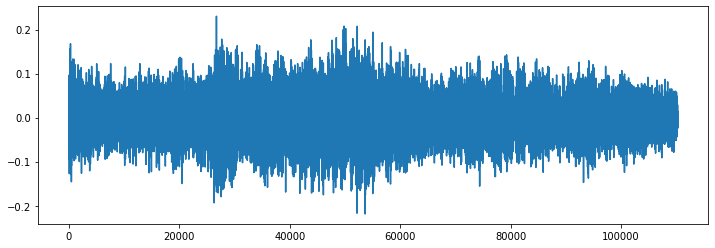

In [ ]:
data_stretch =stretch(librosa_load, 0.8, input_length)
fig = plt.figure(figsize=(12, 4))
plt.plot(data_stretch)

Higher pitch

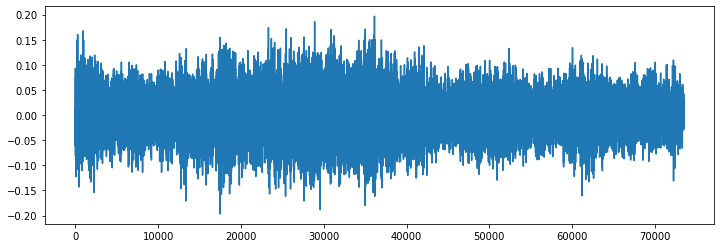

In [ ]:
data_stretch =stretch(librosa_load, 1.2, input_length)
fig = plt.figure(figsize=(12, 4))
plt.plot(data_stretch)

# Mel-Scaled Spectogram
To plot the spectrogram we break the audio signal into millisecond chunks and compute STFT for each. We then plot this time chunk as a colored vertical line in the spectrogram where the hues represent decibel levels (or amplitude).

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

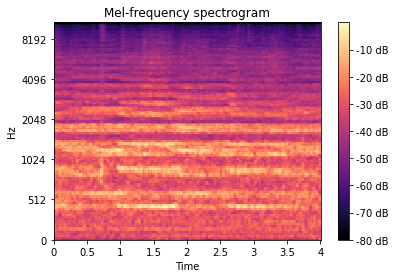

In [ ]:
import librosa.display

fig, ax = plt.subplots()
S = librosa.feature.melspectrogram(librosa_load, librosa_sampling_rate)
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=librosa_sampling_rate,
                         ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

# Extract the features
Mel Frequency Cepstral Co-efficients (MFCC)

Mel scale is a scale that relates the perceived frequency of a tone to the actual measured frequency. 

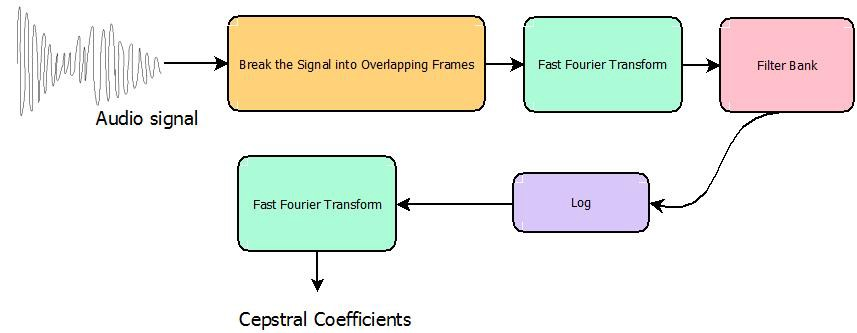

Extract features - no augmentation

In [ ]:
features = []
def get_features(file_name):
  fullpath,label = path_class(file_name)
  librosa_load, librosa_sampling_rate = librosa.load(fullpath)

  S = librosa.feature.melspectrogram(librosa_load, librosa_sampling_rate)
  mel = np.mean(S.T, axis=0)
  features.append(mel)

In [ ]:
for i in tqdm(data.slice_file_name):
  get_features(i) 

Save the features as a numpy binary file for future use

In [ ]:
features = np.array(features)
print(features.shape)
np.save('UrbanSound8K/features.npy', features)

Extract features - with augmentation

This is to increase dataset size by 4

In [ ]:
features_aug = []
def get_features_aug(file_name):
  fullpath,label = path_class(file_name)
  librosa_load, librosa_sampling_rate = librosa.load(fullpath)

  S = librosa.feature.melspectrogram(librosa_load, librosa_sampling_rate)
  mel = np.mean(S.T, axis=0)
  features_aug.append(mel)

  # shift time
  data_roll = np.roll(librosa_load, 40000)

  S = librosa.feature.melspectrogram(data_roll, librosa_sampling_rate)
  mel = np.mean(S.T, axis=0)
  features_aug.append(mel)

  # change pitch
  start = data[data.slice_file_name==file_name]['start']
  end = data[data.slice_file_name==file_name]['end']
  input_length = int(end-start)

  # deepen pitch
  data_stretch = librosa.effects.time_stretch(librosa_load, 0.8)
  data_stretch = np.pad(data_stretch, (0, max(0, input_length - len(data_stretch))), "constant")

  S = librosa.feature.melspectrogram(data_stretch, librosa_sampling_rate)
  mel = np.mean(S.T, axis=0)
  features_aug.append(mel)

  # higher pitch
  data_stretch = librosa.effects.time_stretch(librosa_load, 1.2)
  data_stretch = np.pad(data_stretch, (0, max(0, input_length - len(data_stretch))), "constant")

  S = librosa.feature.melspectrogram(data_stretch, librosa_sampling_rate)
  mel = np.mean(S.T, axis=0)
  features_aug.append(mel)

In [ ]:
for i in tqdm(data.slice_file_name):
  get_features_aug(i)

 24%|██▍       | 2122/8732 [30:08<1:16:45,  1.44it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1781
  n_fft, y.shape[-1]
 24%|██▍       | 2123/8732 [30:09<1:03:00,  1.75it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2018
  n_fft, y.shape[-1]
 25%|██▌       | 2208/8732 [31:26<1:41:16,  1.07it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1838
  n_fft, y.shape[-1]
 34%|███▍      | 3012/8732 [43:38<40:01,  2.38it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1948
  n_fft, y.shape[-1]
 41%|████      | 3555/8732 [51:08<1:36:19,  1.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too s

In [ ]:
features_aug = np.array(features_aug)
print(features_aug.shape)
np.save('UrbanSound8K/features_aug.npy', features_aug)

(34928, 128)


Create and save the melspectrogram as images

In [ ]:
def convert_to_melspectrogram(file_name):
  fullpath,label = path_class(file_name)
  librosa_load, librosa_sampling_rate = librosa.load(fullpath)

  fig = plt.figure()
  ax = fig.add_subplot(1,1,1)
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.set_frame_on(False)

  S = librosa.feature.melspectrogram(librosa_load, librosa_sampling_rate)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB)

  img_filename = fullpath.replace('audio','image')
  img_filename = img_filename.replace('.wav','.png')
  fig.savefig(img_filename,dpi=400, bbox_inches='tight',pad_inches=0)
  plt.close('all')

Create metadata csv for images

In [ ]:
data['slice_file_name'] = data['slice_file_name'].replace({'.wav': '.png'}, regex=True)
data.to_csv('UrbanSound8K/metadata/UrbanSound8K_image.csv')

## Splitting the iteration into 8 parts to save images

In [ ]:
sliced_names = np.array_split(data['slice_file_name'], 8)

First iteration

In [ ]:
for i in tqdm(sliced_names[0]):
    convert_to_melspectrogram(i)

### **Free up RAM space**

In [ ]:
import gc
gc.collect()

Second iteration

In [ ]:
for i in tqdm(sliced_names[1]):
    convert_to_melspectrogram(i)

Third iteration

In [ ]:
for i in tqdm(sliced_names[2]):
    convert_to_melspectrogram(i)

Fourth iteration

In [ ]:
for i in tqdm(sliced_names[3]):
    convert_to_melspectrogram(i)

Fifth iteration

In [ ]:
for i in tqdm(sliced_names[4]):
    convert_to_melspectrogram(i)

Sixth iteration

In [ ]:
for i in tqdm(sliced_names[5]):
    convert_to_melspectrogram(i)

Seventh iteration

In [ ]:
for i in tqdm(sliced_names[6]):
    convert_to_melspectrogram(i)

Eight (and final) iteration

In [ ]:
for i in tqdm(sliced_names[7]):
    convert_to_melspectrogram(i)

# Target vectors

In [ ]:
from keras.utils.np_utils import to_categorical

target = data['classID']
target = np.array(target)
target = to_categorical(target)
np.save('UrbanSound8K/target.npy', target)

Convert to binary classes for **future work**

In [ ]:
target_bin = data['classID']
target_bin = np.array(target_bin)
for i in range(len(target_bin)):
  if target_bin[i]==8:
    target_bin[i] = 1
  else:
    target_bin[i] = 0
target_bin = to_categorical(target_bin)
np.save('UrbanSound8K/target_bin.npy', target_bin)

Target vector for the augmented dataset for **future work**

In [ ]:
target_aug = []
for i in data['classID']:
  for j in range(4):
    target_aug.append(i)
target_aug = np.array(target_aug)
target_aug = to_categorical(target_aug)
np.save('UrbanSound8K/target_aug.npy', target_aug)

In [ ]:
target_aug.shape

Convert to binary classes for **future work**

In [ ]:
target_bin_aug = []
for i in data['classID']:
  for j in range(4):
    target_bin_aug.append(i)
target_bin_aug = np.array(target_bin_aug)
for i in range(len(target_bin_aug)):
  if target_bin_aug[i]==8:
    target_bin_aug[i] = 1
  else:
    target_bin_aug[i] = 0
target_bin_aug = to_categorical(target_bin_aug)
np.save('UrbanSound8K/target_bin_aug.npy', target_bin_aug)

In [ ]:
target_bin_aug.shape